In [51]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("framingham.csv")

# Missing values are removed to simplify preprocessing.
# Although this may reduce the dataset size, it ensures that
# the model receives clean and valid numerical inputs.
df = df.dropna()

# Separate features and target
# X contains all independent variables, while y contains the
# binary label indicating heart disease presence.
X = df.drop("TenYearCHD", axis=1).values
y = df["TenYearCHD"].values


In [52]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,stratify=y, test_size=0.2, random_state=42
)


In [53]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [54]:
class LogisticRegressionScratch:
    def __init__(self, lr=0.01, epochs=1000):
        self.lr = lr
        self.epochs = epochs
        self.losses = []   

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def loss(self, y, y_pred):
        epsilon = 1e-9
        return -np.mean(
            y * np.log(y_pred + epsilon) +
            (1 - y) * np.log(1 - y_pred + epsilon)
        )

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.epochs):
            linear_model = np.dot(X, self.weights) + self.bias
            y_pred = self.sigmoid(linear_model)

            current_loss = self.loss(y, y_pred)
            self.losses.append(current_loss)   

            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / n_samples) * np.sum(y_pred - y)

            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_pred = self.sigmoid(linear_model)
        return np.where(y_pred >= 0.3, 1, 0)



In [55]:
import time

scratch_model = LogisticRegressionScratch(lr=0.01, epochs=2000)

start = time.time()
scratch_model.fit(X_train, y_train)
scratch_time = time.time() - start

y_pred_scratch = scratch_model.predict(X_test)


In [56]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

scratch_metrics = {
    "Accuracy": accuracy_score(y_test, y_pred_scratch),
    "Precision": precision_score(y_test, y_pred_scratch),
    "Recall": recall_score(y_test, y_pred_scratch),
    "F1": f1_score(y_test, y_pred_scratch),
    "Training Time (s)": scratch_time
}

scratch_metrics


{'Accuracy': 0.8087431693989071,
 'Precision': 0.35106382978723405,
 'Recall': 0.29464285714285715,
 'F1': 0.32038834951456313,
 'Training Time (s)': 0.6151776313781738}

In [57]:
from sklearn.linear_model import LogisticRegression

sk_model = LogisticRegression(class_weight = "balanced", max_iter=2000)

start = time.time()
sk_model.fit(X_train, y_train)
sk_time = time.time() - start

y_pred_sk = sk_model.predict(X_test)

#Although the accuracy is relatively high, the F1-score is low due to poor recall,
#indicating that the model misses a large number of positive heart disease cases. 
#This is caused by class imbalance and the use of a default decision threshold. 
#Since heart disease prediction prioritizes identifying positive cases, recall and 
#F1-score are more meaningful metrics than accuracy. Threshold tuning and class-weight balancing can significantly improve F1-score.

In [58]:
sk_metrics = {
    "Accuracy": accuracy_score(y_test, y_pred_sk),
    "Precision": precision_score(y_test, y_pred_sk),
    "Recall": recall_score(y_test, y_pred_sk),
    "F1": f1_score(y_test, y_pred_sk),
    "Training Time (s)": sk_time
}

sk_metrics


{'Accuracy': 0.6926229508196722,
 'Precision': 0.28679245283018867,
 'Recall': 0.6785714285714286,
 'F1': 0.40318302387267907,
 'Training Time (s)': 0.04224276542663574}

In [59]:
comparison = pd.DataFrame([scratch_metrics, sk_metrics],
                           index=["From Scratch", "Scikit-learn"])
comparison

#In heart disease prediction, recall represents the model’s ability to correctly identify patients who actually have the disease,
#while precision indicates how reliable the positive predictions are. The scikit-learn logistic regression model achieved a substantially 
#higher recall (0.68), meaning it successfully detected most patients at risk of heart disease, which is critical in clinical screening scenarios.
#Although its precision was lower, false positives are generally less harmful than missed diagnoses in medical settings. 
#The from-scratch model, despite higher accuracy, showed lower recall, indicating a higher risk of failing to identify affected patients. 
#Therefore, the scikit-learn model is more clinically appropriate due to its stronger emphasis on patient safety and early detection.


,Accuracy,Precision,Recall,F1,Training Time (s)
From Scratch,0.808743,0.351064,0.294643,0.320388,0.615178
Scikit-learn,0.692623,0.286792,0.678571,0.403183,0.042243


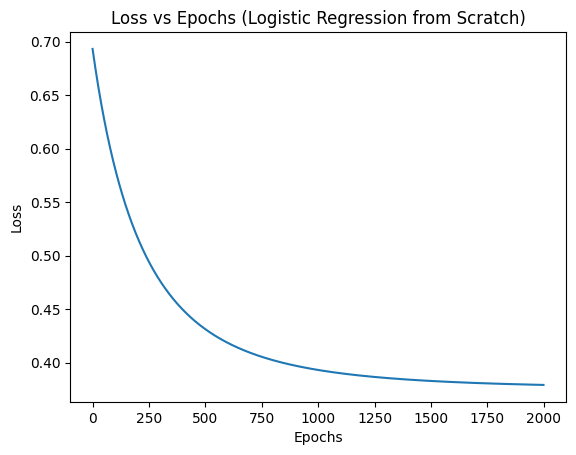

In [60]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(scratch_model.losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs (Logistic Regression from Scratch)")
plt.show()


In [61]:
# Plot loss versus epochs to observe the convergence behavior
# of the gradient descent algorithm. A decreasing loss curve
# indicates that the model is learning effectively.

In [62]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

<Figure size 640x480 with 0 Axes>

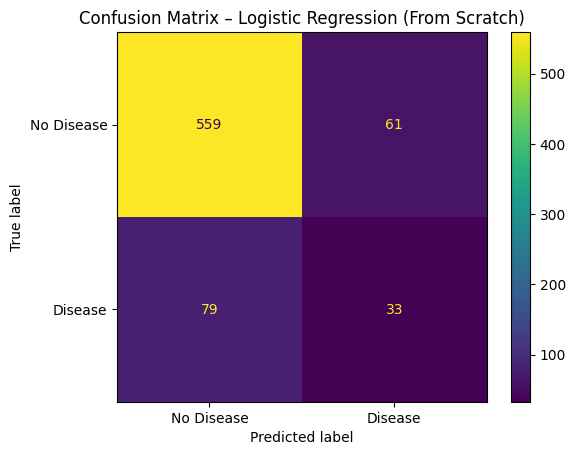

In [63]:
# Predictions from scratch model
y_pred_scratch = scratch_model.predict(X_test)

# Compute confusion matrix
cm_scratch = confusion_matrix(y_test, y_pred_scratch)

# Plot
plt.figure()
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_scratch,
    display_labels=["No Disease", "Disease"]
)
disp.plot()
plt.title("Confusion Matrix – Logistic Regression (From Scratch)")
plt.show()

<Figure size 640x480 with 0 Axes>

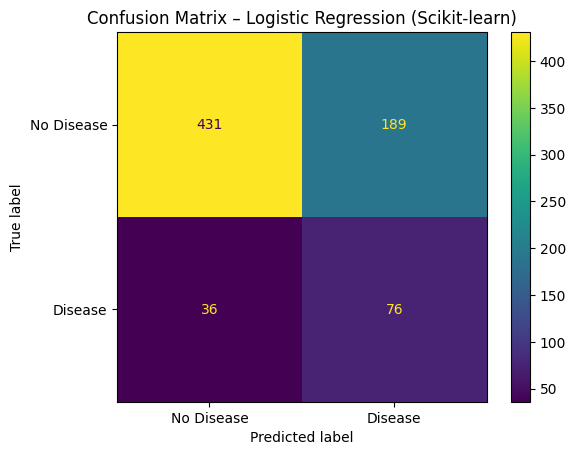

In [64]:
# Predictions from scikit-learn model
y_pred_sk = sk_model.predict(X_test)

# Compute confusion matrix
cm_sk = confusion_matrix(y_test, y_pred_sk)

# Plot
plt.figure()
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_sk,
    display_labels=["No Disease", "Disease"]
)
disp.plot()
plt.title("Confusion Matrix – Logistic Regression (Scikit-learn)")
plt.show()